In [40]:
!pip install torch torchvision
!pip install -U finance-datareader


Requirement already up-to-date: finance-datareader in /usr/local/lib/python3.6/dist-packages (0.9.6)


In [0]:
import FinanceDataReader as fdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
import time
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
import FinanceDataReader as fdr

In [42]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
class TestDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime.now() - datetime.timedelta(days=int(x_frames+y_frames)*2)
        self.end = datetime.date.today()
        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        self.data = self.data.tail(x_frames+y_frames)
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
class TestDataset2(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime.now() - datetime.timedelta(days=int(x_frames+y_frames)*2)
        self.end = datetime.date.today()
        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        self.data = self.data.tail(x_frames+y_frames)
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        #data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [0]:
class PredictDataset(Dataset):
    
    def __init__(self, symbol, x_frames):
        
        self.symbol = symbol
        self.x_frames = x_frames
        
        self.start = datetime.datetime.now() - datetime.timedelta(days=(x_frames*2))
        self.end = datetime.date.today()
        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        self.data = self.data.tail(x_frames)
        
    def __len__(self):
        return len(self.data) - (self.x_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        
        return X

In [0]:
class PredictDataset2(Dataset):
    
    def __init__(self, symbol, x_frames):
        
        self.symbol = symbol
        self.x_frames = x_frames
        
        self.start = datetime.datetime.now() - datetime.timedelta(days=(x_frames*2))
        self.end = datetime.date.today()
        self.data = fdr.DataReader(self.symbol, self.start, self.end)
        self.data = self.data.tail(x_frames)
        
    def __len__(self):
        return len(self.data) - (self.x_frames) + 1
    
    def __getitem__(self, idx):
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx]
        data = data[['High', 'Low', 'Open', 'Close', 'Change', 'Volume']]
        #data = data.apply(lambda x: (x+1) / (x[self.x_frames-1]+1))
        data = data.values
        X = data[:self.x_frames]
        
        return X

In [0]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        return y_pred

In [0]:
#테스트 데이터 생성
symbols = "001040,001450,024110,020150,102110,071050,086790,003670,032830,010950,005830,005940,180640,081660,003410,004020,005490,000120,051900,002790,122630,047810,011170,128940,005380,078930,011780,021240,036460,051910,006800,035420,034220,097950,011070,008770,000210,251270,000080,000720,018880,011790,005387,030200,018260,033780,008560,153130,012510,271560,012330,035720,015760,003550,028260,161390,028050,029780,007070,009540,069500,036570,009150,096770,090430,005930,005935,241560,105560,252670,000270,032640,004170,086280,012750,000660,010130,267250,004990,066570,009830,282330,023530,000810,316140,016360,139480,009240,017670,088980,034730,006400,000100,207940,006360,055550,035250,010140,007310,068270".split(",")

In [48]:
batch_size = 1
input_dim = 6
hidden_dim = 50
num_layers = 1
input_frame = 5
output_frame = input_frame

model = LSTM(input_dim,hidden_dim,output_frame,num_layers,batch_size)
modelPath = '/content/gdrive/My Drive/LSTM_batch_1_model.pt'
model.load_state_dict(torch.load(modelPath))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.to(device)

LSTM(
  (lstm): LSTM(6, 50)
  (regressor): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=5, bias=True)
  )
)

In [79]:
result = {}
for sb in symbols:
    testset = TestDataset(sb,input_frame,output_frame)
    
    model.eval()
    plr = DataLoader(testset,batch_size,shuffle=False)

    for (X,y) in plr:
        X = X.transpose(0, 1).float().to(device)
        y_true = y[:, :, 3].float().to(device)
        model.hidden = [hidden.to(device) for hidden in model.init_hidden()]
        y_pred = model(X)
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)
        y_pred = np.exp(y_pred.cpu().detach().numpy())
        y_true = np.exp(y_true.cpu().detach().numpy())
        result[sb] = (y_pred/y_true)[-1]
        print((y_pred/y_true)[-1])


0.9797095
0.91459244
0.820266
0.95452034
0.8964393
0.92474073
0.92775613
0.88665897
0.8821902
0.9046159
0.8831923
0.87624925
0.9308756
0.8737692
0.91618085
0.86394376
0.87773
0.95800567
0.9550638
0.9541481
0.8174139
0.9214692
0.9523908
0.8854588
0.85582644
0.9135455
0.90534264
0.88738936
0.92850596
0.8760541
0.8593304
0.95575655
0.8118851
0.9713855
0.9375644
0.93006015
0.94729227
0.92917943
0.9280494
0.89603597
0.9300186
0.95595
0.85962254
0.9408746
1.0086863
0.92705625
0.8854994
0.97855043
1.0987465
0.9886683
0.8779526
1.0262709
0.9462973
0.8274685
0.85848385
0.8861598
0.8711849
0.93376845
1.0044742
0.8607979
0.89628947
0.95873904
0.9285807
0.9154195
0.9086651
0.88887805
0.8718678
0.8487221
0.8680432
1.1473544
0.91110796
0.96597964
0.9495464
0.8706447
0.97199035
0.87687886
0.9556367
0.9398146
0.9204529
0.9187634
0.9351529
1.05053
0.93080956
0.87871754
0.8820007
0.8801068
0.9372795
0.907764
0.9427227
0.98899144
0.90859985
0.94639635
0.9789174
0.91307724
0.94760025
0.8321677
0.92200696


In [80]:
result2 = {}
for sb in symbols:
    testset2 = TestDataset2(sb,input_frame,output_frame)
    
    plr = DataLoader(testset2,batch_size,shuffle=False)

    for (X,y) in plr:
        y_true = y[:, :, 3].float().to(device)
        y_true = y_true.view(-1)
        result2[sb] = y_true[-1]
        print(y_true[-1])


tensor(91600., device='cuda:0')
tensor(25850., device='cuda:0')
tensor(9730., device='cuda:0')
tensor(47900., device='cuda:0')
tensor(29105., device='cuda:0')
tensor(55600., device='cuda:0')
tensor(31250., device='cuda:0')
tensor(61000., device='cuda:0')
tensor(50400., device='cuda:0')
tensor(76300., device='cuda:0')
tensor(47800., device='cuda:0')
tensor(10800., device='cuda:0')
tensor(90700., device='cuda:0')
tensor(42800., device='cuda:0')
tensor(5400., device='cuda:0')
tensor(24550., device='cuda:0')
tensor(200500., device='cuda:0')
tensor(164000., device='cuda:0')
tensor(1401000., device='cuda:0')
tensor(59100., device='cuda:0')
tensor(13160., device='cuda:0')
tensor(26850., device='cuda:0')
tensor(193000., device='cuda:0')
tensor(260500., device='cuda:0')
tensor(111000., device='cuda:0')
tensor(40250., device='cuda:0')
tensor(76400., device='cuda:0')
tensor(73000., device='cuda:0')
tensor(31350., device='cuda:0')
tensor(434000., device='cuda:0')
tensor(6960., device='cuda:0')
ten

In [0]:
pred = []
real = []
result3 = {}
for i in result:
    result3[i] = result[i] * result2[i]
    pred.append(result3[i])
    real.append(result2[i])

In [87]:
print(result3)
print(result2)
print(pred)
print(real)

{'001040': tensor(89741.3906, device='cuda:0'), '001450': tensor(23642.2148, device='cuda:0'), '024110': tensor(7981.1885, device='cuda:0'), '020150': tensor(45721.5234, device='cuda:0'), '102110': tensor(26090.8672, device='cuda:0'), '071050': tensor(51415.5859, device='cuda:0'), '086790': tensor(28992.3789, device='cuda:0'), '003670': tensor(54086.1953, device='cuda:0'), '032830': tensor(44462.3867, device='cuda:0'), '010950': tensor(69022.1953, device='cuda:0'), '005830': tensor(42216.5938, device='cuda:0'), '005940': tensor(9463.4922, device='cuda:0'), '180640': tensor(84430.4141, device='cuda:0'), '081660': tensor(37397.3242, device='cuda:0'), '003410': tensor(4947.3765, device='cuda:0'), '004020': tensor(21209.8184, device='cuda:0'), '005490': tensor(175984.8750, device='cuda:0'), '000120': tensor(157112.9219, device='cuda:0'), '051900': tensor(1338044.3750, device='cuda:0'), '002790': tensor(56390.1523, device='cuda:0'), '122630': tensor(10757.1670, device='cuda:0'), '047810': t

Text(0.5, 1.0, 'pred vs real')

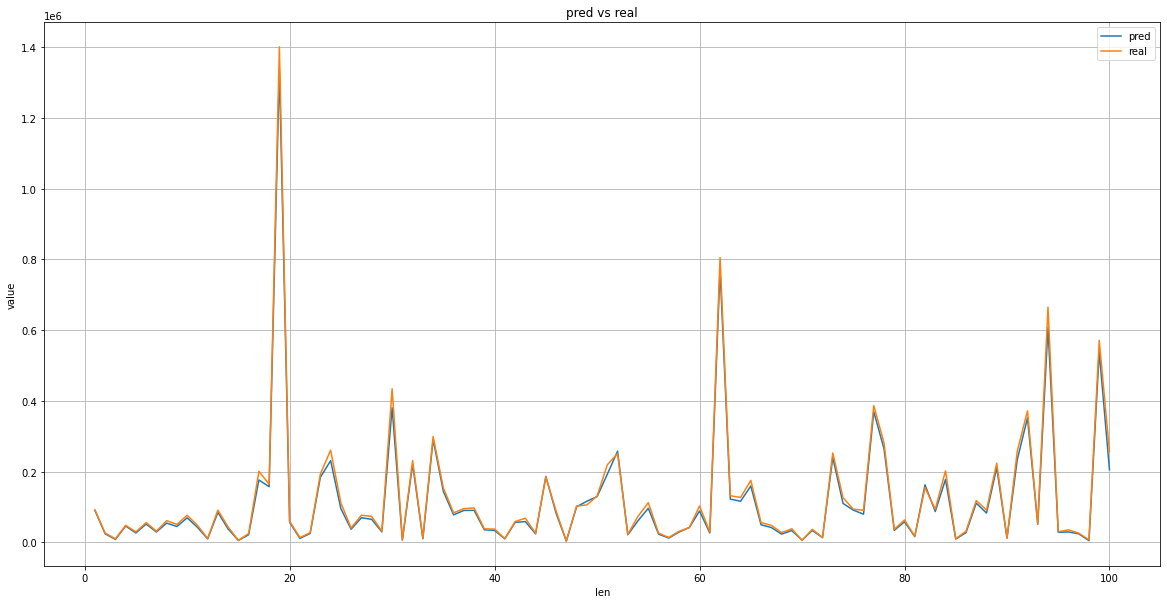

In [89]:
%matplotlib inline
#데이터 생성과 화면 표시를 위한 라이브러리 호출
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(20,10))
xl = [n for n in range(1,len(pred)+1)]

# ====== test plot ====== #
ax = fig.add_subplot(1, 1, 1)
ax.plot(xl, pred, label='pred')
ax.plot(xl, real, label='real')
ax.set_xlabel('len')
ax.set_ylabel('value')
ax.grid()
ax.legend()
ax.set_title('pred vs real')

In [83]:
ok = fdr.DataReader('001040')

ok.tail(10)

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-05-25,88600,91400,88100,91000,115356,0.027088
2020-05-26,91800,92400,88600,88800,122131,-0.024176
2020-05-27,89000,91500,88800,89100,124717,0.003378
2020-05-28,88500,89300,84900,87100,130808,-0.022447
2020-05-29,87000,91900,86100,91900,142308,0.055109
2020-06-01,90300,92000,89600,92000,71829,0.001088
2020-06-02,90400,92300,90300,91700,63436,-0.003261
2020-06-03,92400,93400,90500,91700,138883,0.000000
2020-06-04,91900,93300,90000,92000,92613,0.003272


In [102]:
pr = PredictDataset('001040',input_frame)
pr2 = PredictDataset2('001040',input_frame)

xx = DataLoader(pr,1,False)
xx2 = DataLoader(pr2,1,False)

predict = 0

for X in xx:
    X = X.transpose(0, 1).float().to(device)
    model.hidden = [hidden.to(device) for hidden in model.init_hidden()]
    y_pred = model(X)
    predict = y_pred
    print(y_pred)

for X in xx2:
    X = X.transpose(0, 1).float().to(device)
    Xtos = X[:,:,3].view(-1)
    predict *= Xtos
    print(Xtos)

print(predict)

tensor([[0.9909, 0.9748, 0.9774, 0.9744, 0.9780]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([92000., 91700., 91700., 92000., 91600.], device='cuda:0')
tensor([[91163.5859, 89386.3906, 89628.9844, 89643.6641, 89585.1875]],
       device='cuda:0', grad_fn=<MulBackward0>)
